In [282]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy

df = pd.read_csv('data/mobile.csv', index_col=0)
print(len(df))
df.head()

400


,battery_power,clock_speed,four_g,int_memory,n_cores,pc,ram,talk_time,touch_screen,wifi,price_range
0,1142,1.4,0,6,8,8,663,5,1,1,0
1,728,1.7,1,5,2,20,834,5,1,0,0
2,1868,0.5,1,40,8,17,298,17,1,0,0
3,890,2.2,0,44,8,13,751,3,0,0,0
4,1433,1.6,0,4,8,11,258,4,1,1,0


In [283]:
cols = ['battery_power', 'int_memory', 'ram']

df = df[cols]
df.head()

,battery_power,int_memory,ram
0,1142,6,663
1,728,5,834
2,1868,40,298
3,890,44,751
4,1433,4,258


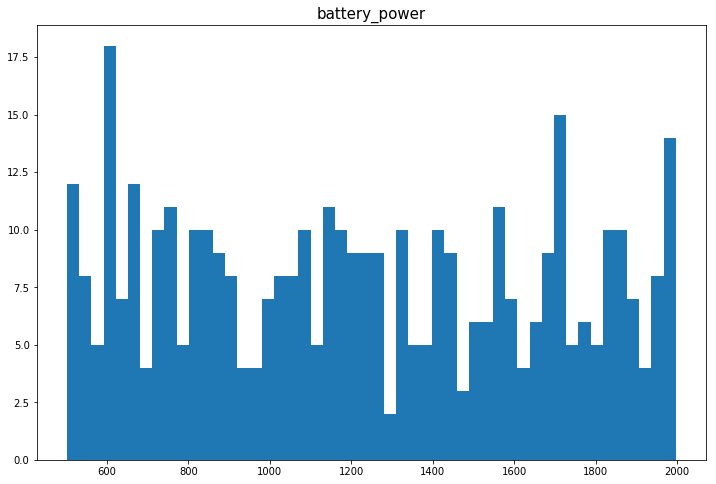

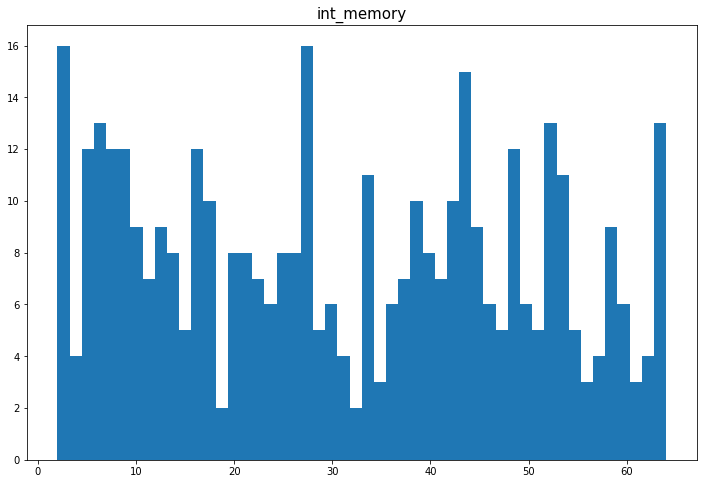

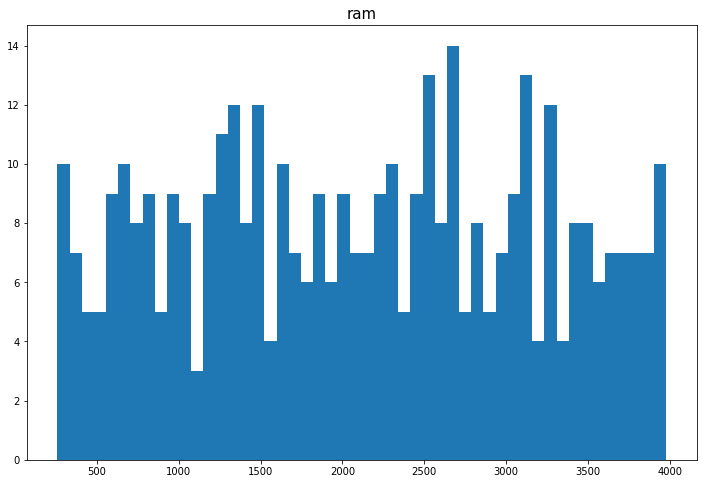

In [284]:
for col in cols:
    plt.figure(figsize=(12,8))
    plt.title(col, size=15)
    plt.hist(df[col], bins=50)
    plt.show()


In [285]:
bat_pivots = [df['battery_power'].min(), 950, 1300, 1600, df['battery_power'].max()]
int_pivots = [df['int_memory'].min(), 19, 32, 55, df['int_memory'].max()]
ram_pivots = [df['ram'].min(), 1000, 2400, 3200, df['ram'].max()]

bat_pivots, int_pivots, ram_pivots

([502, 950, 1300, 1600, 1997],
 [2, 19, 32, 55, 64],
 [258, 1000, 2400, 3200, 3978])

In [292]:
def generate_cont_freq(pivots_list, initial_df, col_name):
    """
    pivots_list - лист пивотов
    initial_df - исходный датафрейм
    col_name - колонка (фича) которую категоризуем
    
    return:
    
    relative frequency table
    conditional frequency table
    
    """
    
    categories_inds = np.zeros(len(initial_df), dtype=int)
    ln = len(categories_inds)

    for i in range(len(bat_pivots) - 1):
        new_df = initial_df[initial_df[col_name] >= pivots_list[i]] # находим нужные элементы попадающие в промежуток
        new_df = new_df[new_df[col_name] <= pivots_list[i+1]]
        categories_inds[new_df.index.tolist()] = i # присваиваем тип категории соответствующим индексам
        
    zer = [0] * 5
    df_cats = pd.DataFrame({'Partitions': ['Part 1', 'Part 2', 'Part 3', 'Part 4', 'Total'], 
                               'Cat 1': zer, 'Cat 2': zer, 'Cat 3': zer, 'Cat 4': zer, 'Total': zer})
    df_cats = df_cats.set_index('Partitions')

    #заполняем табличку
    
    for i in range(4):
        cur_slice = np.arange(i * 100, i*100 + 100)
        for j in cur_slice:
            df_cats.iloc[i, categories_inds[j]] += 1

    df_cats['Total'] = [np.sum(df_cats.iloc[i,0:4]) for i in range(5)]
    colsum = df_cats.sum(axis=0).tolist()

    for i in range(5):
        df_cats.iloc[4,i] = colsum[i]
        
    # нормализация:    
    
    df_cats = df_cats / ln
    df_cats_freq = deepcopy(df_cats)
    
    for i in range(4):
        for j in range(4):
            df_cats_freq.iloc[i,j] = df_cats_freq.iloc[i,j] / df_cats_freq.iloc[-1,j]
    
    df_cats_freq = df_cats_freq.iloc[:-1,:-1]
    return df_cats, df_cats_freq

In [309]:
def generate_quetlet(rel_freq_table):
    """
    rel_freq_table - relative frequency table
    """
    
    quet_table = deepcopy(rel_freq_table)
    ln = len(rel_freq_table)
    
    for i in range(ln-1):
        for j in range(ln-1):
            quet_table.iloc[i,j] = cont.iloc[i,-1] * cont.iloc[-1,j]
            
    quet_table = rel_freq_table.divide(quet_table)
    quet_table = quet_table.subtract(1)

    return quet_table.iloc[:-1,:-1]

In [327]:
def get_chi2(rel_freq_table, quet_table):
    chi_table = rel_freq_table.iloc[:-1,:-1].multiply(quet_table)
    return chi_table, chi_table.values.sum()

In [335]:
bat_rel_freq, bat_cond_freq = generate_cont_freq(bat_pivots, df, 'battery_power')
bat_quet = generate_quetlet(bat_rel_freq)
bat_chi2_table, bat_chi2_value = get_chi2(bat_rel_freq, bat_quet)
print('Conditional frequency table:')
print(bat_cond_freq, '\n')
print('Quetlet relative index table:')
print(bat_quet, '\n')
print('Chi-squared matrix:')
print(bat_chi2_table, '\n')
print('Chi-square value:')
print(bat_chi2_value)

Conditional frequency table:
               Cat 1     Cat 2     Cat 3     Cat 4
Partitions                                        
Part 1      0.330827  0.277778  0.140845  0.198113
Part 2      0.255639  0.277778  0.295775  0.188679
Part 3      0.278195  0.211111  0.225352  0.264151
Part 4      0.135338  0.233333  0.338028  0.349057 

Quetlet relative index table:
               Cat 1     Cat 2     Cat 3     Cat 4
Partitions                                        
Part 1      0.323308  0.111111 -0.436620 -0.207547
Part 2      0.022556  0.111111  0.183099 -0.245283
Part 3      0.112782 -0.155556 -0.098592  0.056604
Part 4     -0.458647 -0.066667  0.352113  0.396226 

Chi-squared matrix:
               Cat 1     Cat 2     Cat 3     Cat 4
Partitions                                        
Part 1      0.035564  0.006944 -0.010915 -0.010896
Part 2      0.001917  0.006944  0.009613 -0.012264
Part 3      0.010432 -0.007389 -0.003944  0.003962
Part 4     -0.020639 -0.003500  0.021127  0.036651

In [337]:
int_rel_freq, int_cond_freq = generate_cont_freq(int_pivots, df, 'int_memory')
int_quet = generate_quetlet(int_rel_freq)
int_chi2_table, int_chi2_value = get_chi2(int_rel_freq, int_quet)

print('Conditional frequency table:')
print(int_cond_freq, '\n')
print('Quetlet relative index table:')
print(int_quet, '\n')
print('Chi-squared matrix:')
print(int_chi2_table, '\n')
print('Chi-square value:')
print(int_chi2_value)

Conditional frequency table:
               Cat 1     Cat 2     Cat 3     Cat 4
Partitions                                        
Part 1      0.240310  0.307692  0.226027  0.255319
Part 2      0.263566  0.217949  0.253425  0.255319
Part 3      0.279070  0.282051  0.232877  0.170213
Part 4      0.217054  0.192308  0.287671  0.319149 

Quetlet relative index table:
               Cat 1     Cat 2     Cat 3     Cat 4
Partitions                                        
Part 1     -0.067669  0.066667  0.859155 -0.547170
Part 2      0.022556 -0.244444  1.084507 -0.547170
Part 3      0.082707 -0.022222  0.915493 -0.698113
Part 4     -0.157895 -0.333333  1.366197 -0.433962 

Chi-squared matrix:
               Cat 1     Cat 2     Cat 3     Cat 4
Partitions                                        
Part 1     -0.005244  0.004000  0.070880 -0.016415
Part 2      0.001917 -0.010389  0.100317 -0.016415
Part 3      0.007444 -0.001222  0.077817 -0.013962
Part 4     -0.011053 -0.012500  0.143451 -0.016274

In [339]:
ram_rel_freq, ram_cond_freq = generate_cont_freq(ram_pivots, df, 'ram')
ram_quet = generate_quetlet(ram_rel_freq)
ram_chi2_table, ram_chi2_value = get_chi2(ram_rel_freq, ram_quet)

print('Conditional frequency table:')
print(ram_cond_freq, '\n')
print('Quetlet relative index table:')
print(ram_quet, '\n')
print('Chi-squared matrix:')
print(ram_chi2_table, '\n')
print('Chi-square value:')
print(ram_chi2_value)

Conditional frequency table:
               Cat 1     Cat 2     Cat 3     Cat 4
Partitions                                        
Part 1      0.896104  0.205298  0.000000  0.000000
Part 2      0.103896  0.576159  0.053191  0.000000
Part 3      0.000000  0.211921  0.617021  0.128205
Part 4      0.000000  0.006623  0.329787  0.871795 

Quetlet relative index table:
               Cat 1     Cat 2     Cat 3     Cat 4
Partitions                                        
Part 1      1.075188  0.377778 -1.000000 -1.000000
Part 2     -0.759398  2.866667 -0.718310 -1.000000
Part 3     -1.000000  0.422222  2.267606 -0.622642
Part 4     -1.000000 -0.955556  0.746479  1.566038 

Chi-squared matrix:
               Cat 1     Cat 2     Cat 3     Cat 4
Partitions                                        
Part 1      0.185470  0.029278 -0.000000 -0.000000
Part 2     -0.015188  0.623500 -0.008979 -0.000000
Part 3     -0.000000  0.033778  0.328803 -0.015566
Part 4     -0.000000 -0.002389  0.057852  0.266226